## Split into train, validation and test sets

In [1]:
from Prep import titanic
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split,  cross_val_score

#Set without scaling
X, X_test, y, y_test = train_test_split(titanic.iloc[:,1:], titanic.iloc[:,0], test_size = 0.1, stratify = titanic.iloc[:,0])
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.11, stratify = y)



print('Training set size: ', X_train.shape, '\n','Validation set size: ', X_validation.shape, '\n','Test set size:', X_test.shape)

Training set size:  (560, 10) 
 Validation set size:  (70, 10) 
 Test set size: (71, 10)


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Model Shotgun Performance

In [3]:
sc_primo = StandardScaler()
X_train = sc_primo.fit_transform(X_train)



models = {'KNN: ': KNeighborsClassifier(),
         'Logistic: ': LogisticRegressionCV(),
         'Naive Bayes: ': GaussianNB(),
          'Support Vector Machine:' : SVC(),
         'Random Forest: ': RandomForestClassifier(n_estimators = 100, n_jobs = -1),
         'AdaBoost: ': AdaBoostClassifier(),
         'GBM: ' : GradientBoostingClassifier()}

for i, mod in enumerate(models.values()):
    print(list(models.keys())[i],cross_val_score(mod, X_train, y_train, cv = 10).mean())
    
    

KNN:  0.82833789018
Logistic:  0.801768056505
Naive Bayes:  0.773093529278
Support Vector Machine: 0.825019366598
Random Forest:  0.810792891319
AdaBoost:  0.787731829574
GBM:  0.83583105491


# Feature Selection

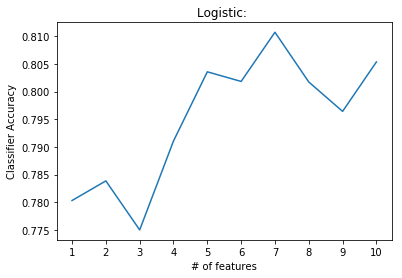

Feature to be Omitted:  ['Parch' 'Embarked_Q' 'Embarked_S']


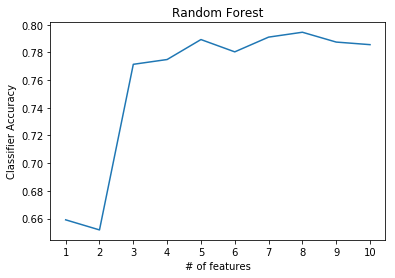

Feature to be Omitted:  ['Embarked_Q' 'Embarked_S']


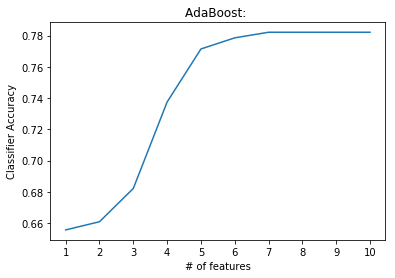

Feature to be Omitted:  []


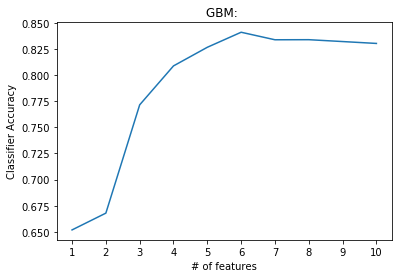

Feature to be Omitted:  ['Parch' 'Embarked_C' 'Embarked_Q' 'Embarked_S']


In [4]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

#Dropping KNN and RandomForest
models = {'Logistic: ': LogisticRegressionCV(),
          'Random Forest': RandomForestClassifier(),
         'AdaBoost: ': AdaBoostClassifier(),
         'GBM: ' : GradientBoostingClassifier()}
for i , mod in enumerate(models.values()):
    r = RFECV(mod, cv = StratifiedKFold(5), scoring = 'accuracy')
    r.fit(X_train, y_train)
    plt.figure()
    plt.plot(range(1, len(r.grid_scores_)+1), r.grid_scores_)
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.xlabel('# of features')
    plt.ylabel('Classifier Accuracy')
    plt.title(str(list(models.keys())[i]))
    plt.show()
    print('Feature to be Omitted: ', titanic.columns[1:][np.array(r.ranking_)!=1].values)
        

# Linear Seperability

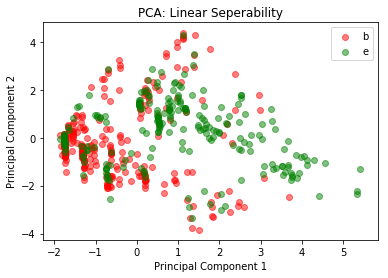

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns

#Make a copy to work on
X_pca = X_train.copy()



#instantiate PCA
pca = PCA()
X_redu = pca.fit_transform(X_pca)


died = X_redu[y_train == 0]
live = X_redu[y_train == 1]
comp =[0,1]

plt.scatter(died[:,0].reshape(1,-1), died[:,1].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
plt.scatter(live[:,0].reshape(1,-1), live[:,1].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.legend('best', scatterpoints = 1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Linear Seperability')
plt.show()


# Model Tweaking

In [6]:
# Overall classifier performance DataFrame
overall_res = pd.DataFrame(columns=['Classifier', 'Best_clf_retrained', 'Best_test_score'])

## AdaBoost Tweak

In [7]:
from sklearn.tree import DecisionTreeClassifier
sc = StandardScaler()
clf = AdaBoostClassifier()
clf_name = 'AdaBoost'

# Make pipeline
pipeline = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__n_estimators':[200],
              'clf__base_estimator':[
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=1, min_samples_split=2),                  
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=4), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=5), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=2, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',                                          
                      min_samples_leaf=2, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=7), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=3, min_samples_split=8),                         
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=6, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=8, min_samples_split=18),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=10, min_samples_split=22),
              ]}
                                                                   
# Initiate GridSearchCV
gs = GridSearchCV(pipeline, fit_params, cv=7, n_jobs = -1, return_train_score = True)

# Fit GridSearchCV
gs.fit(X, y)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_.fit(X, y), 
                            'Best_test_score': gs.best_score_}, ignore_index=True);
print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

Best performing classifier parameters (score 0.7698412698412699):
{'clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'clf__n_estimators': 200}
